In [1]:
# !pip install transformers==4.51.3

In [2]:
!pip install transformers datasets accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 122.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


#### General setup:

In [4]:
import math

In [5]:
emotion_to_label_binary = {
    "neutral": 0,
    "non-neutral": 1,
    "happy": 1, "anger": 1, "sad": 1,
    "surprise": 1, "fear": 1, "disgust": 1
}

label_to_binary = {
    'LABEL_0': "neutral",
    'LABEL_1': "non-neutral"
}

emotion_to_label = {
    "neutral": 0, "happy": 1, "anger": 2, "sad": 3,
    "surprise": 4, "fear": 5, "disgust": 6
}

label_to_emotion = {
    'LABEL_0': "neutral",
    'LABEL_1': "happy",
    'LABEL_2': "anger",
    'LABEL_3': "sad",
    'LABEL_4': "surprise",
    'LABEL_5': "fear",
    'LABEL_6': "disgust"
}

non_neutral_to_label = {
    "happy": 0, "anger": 1, "sad": 2,
    "surprise": 3, "fear": 4, "disgust": 5
}

label_to_non_neutral = {
    'LABEL_0': "happy",
    'LABEL_1': "anger",
    'LABEL_2': "sad",
    'LABEL_3': "surprise",
    'LABEL_4': "fear",
    'LABEL_5': "disgust"
}

###### GCP login:

In [6]:
from google.colab import auth

In [7]:
auth.authenticate_user()

In [8]:
!gcloud auth login --quiet

Go to the following link in your browser, and complete the sign-in prompts:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fsdk.cloud.google.com%2Fauthcode.html&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=PipgUacVFxFRLVINPeV6ZEJhcg4wVT&prompt=consent&token_usage=remote&access_type=offline&code_challenge=DipEJ4a9XkevmbEh0OZHRLtqVH57YuYJXmHZ3jGRiNw&code_challenge_method=S256

Once finished, enter the verification code provided in your browser: 4/0AUJR-x6uLC2pUO_KpcX9MPLzHAYD9HzLT7UNUtx3gbd0giX3O482aAx967OI21qmJpkyJA

You are now logged in as [khrystyna.dol.3@gmail.com].
Your current proj

In [9]:
!gcloud config set project ser-diploma

Updated property [core/project].


##### Data loading from GCP bucket:

In [10]:
import pandas as pd
import gcsfs

fs = gcsfs.GCSFileSystem(project='ser-diploma')
gcs_path = 'gs://mc-eiu-data/MC-EIU-processed_final.csv'

with fs.open(gcs_path, 'r') as f:
    df = pd.read_csv(f)

df.head()

,audio_file,audio_file_local,text,emotion,intent,speaker,dialogue_id,utterance_id,emotion_label,binary_label
0,gs://mc-eiu-data/MC-EIU-audio/dia_1_utt_0.mp3,/content/mc-eiu-data/dia_1_utt_0.mp3,"Ross: Hi... There she is. Hi Emma. Oh my God,...",happy,questioning,0,1,0,1,1
1,gs://mc-eiu-data/MC-EIU-audio/dia_1_utt_1.mp3,/content/mc-eiu-data/dia_1_utt_1.mp3,"Rachel: That was one time, Ross, and they were...",neutral,neutral,1,1,1,0,0
2,gs://mc-eiu-data/MC-EIU-audio/dia_1_utt_2.mp3,/content/mc-eiu-data/dia_1_utt_2.mp3,"Ross: Ooh hey, Emma, daddy has some presents f...",neutral,wishing,0,1,2,0,0
3,gs://mc-eiu-data/MC-EIU-audio/dia_1_utt_3.mp3,/content/mc-eiu-data/dia_1_utt_3.mp3,"Rachel: Aaah... Ross, actually there's somethi...",anger,neutral,1,1,3,2,1
4,gs://mc-eiu-data/MC-EIU-audio/dia_1_utt_4.mp3,/content/mc-eiu-data/dia_1_utt_4.mp3,"Ross: Okay, shoot! \n",neutral,agreeing,0,1,4,0,0


#### Emotion Recommendation:

Main imports:

In [11]:
import os
import math
import time

import torch
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

# from google.colab import files

##### Data Preparation:

###### Binary data:

In [12]:
binary_df = df[['text', 'binary_label']].copy()
binary_df.head()

,text,binary_label
0,"Ross: Hi... There she is. Hi Emma. Oh my God,...",1
1,"Rachel: That was one time, Ross, and they were...",0
2,"Ross: Ooh hey, Emma, daddy has some presents f...",0
3,"Rachel: Aaah... Ross, actually there's somethi...",1
4,"Ross: Okay, shoot! \n",0


In [13]:
binary_df['binary_label'].value_counts()

,count
binary_label,
1,23579
0,21428


In [14]:
binary_df = binary_df[binary_df['text'] != '-']
binary_df['binary_label'].value_counts()

,count
binary_label,
0,12488
1,10252


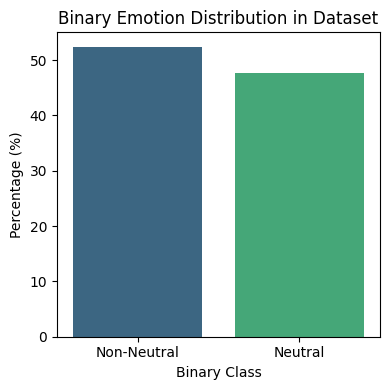

In [ ]:
binary_emotion_counts = df['binary_label'].value_counts(normalize=True) * 100

label_names = {0: 'Neutral', 1: 'Non-Neutral'}

plot_df = pd.DataFrame({
  "Class": [label_names[label] for label in binary_emotion_counts.index],
  "Percentage": binary_emotion_counts.values
})

fig, ax = plt.subplots(figsize=(4, 4))
sns.barplot(data=plot_df, x="Class", y="Percentage", hue="Class", palette="viridis", ax=ax, legend=False)

ax.set_title('Binary Emotion Distribution in Dataset')
ax.set_xlabel('Binary Class')
ax.set_ylabel('Percentage (%)')

plt.tight_layout()
plt.show()

In [ ]:
binary_df['binary_label'].value_counts()

,count
binary_label,
0,12488
1,10252


###### Non-neutral emotions data:

In [41]:
emotion_df = df[['text', 'emotion_label']].copy()
emotion_df = emotion_df[emotion_df['emotion_label'] != 0].reset_index(drop=True)

emotion_df['emotion_label'], _ = pd.factorize(emotion_df['emotion_label'])
emotion_df.head()

,text,emotion_label
0,"Ross: Hi... There she is. Hi Emma. Oh my God,...",0
1,"Rachel: Aaah... Ross, actually there's somethi...",1
2,Ross: OH NO! \n,1
3,"Ross: Oh, it's all over everything. Why? Why m...",1
4,Rachel: Because you took three hundred bottles...,2


In [42]:
emotion_df = emotion_df[emotion_df['text'] != '-'].reset_index(drop=True)

In [43]:
emotion_df['emotion_label'].value_counts()

,count
emotion_label,
0,5081
1,2029
2,1052
3,902
5,844
4,344


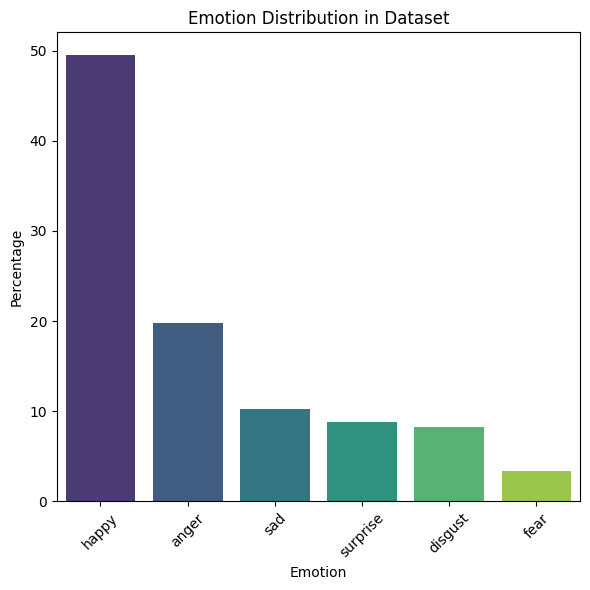

In [44]:
label_to_emotion = {v: k for k, v in non_neutral_to_label.items()}
emotion_counts_i = emotion_df['emotion_label'].value_counts(normalize=True) * 100

plot_df = pd.DataFrame({
    "Emotion": [label_to_emotion[label] for label in emotion_counts_i.index],
    "Percentage": emotion_counts_i.values
})

fig, ax = plt.subplots(figsize=(6, 6))
sns.barplot(data=plot_df, x="Emotion", y="Percentage", hue="Emotion", palette="viridis", ax=ax, legend=False)

ax.set_title('Emotion Distribution in Dataset')
ax.set_xlabel('Emotion')
ax.set_ylabel('Percentage')
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [45]:
happy_df = emotion_df[emotion_df['emotion_label'] == 0]
happy_df_reduced = happy_df.sample(frac=0.5, random_state=42)

others_df = emotion_df[emotion_df['emotion_label'] != 0]

emotion_df_reduced = pd.concat([happy_df_reduced, others_df], ignore_index=True)
emotion_df = emotion_df_reduced.sample(frac=1, random_state=42).reset_index(drop=True)
emotion_df.head()

,text,emotion_label
0,Chandler: But it's all so overwhelming. I don'...,2
1,"Gloria : Well, batman doesn't get picked on, a...",1
2,"Rachel: No. No, I don't. Could you be a dear a...",2
3,Joey: I think so. \n,2
4,"Ross: Hmm? Oh, a student I don’t know. \n",3


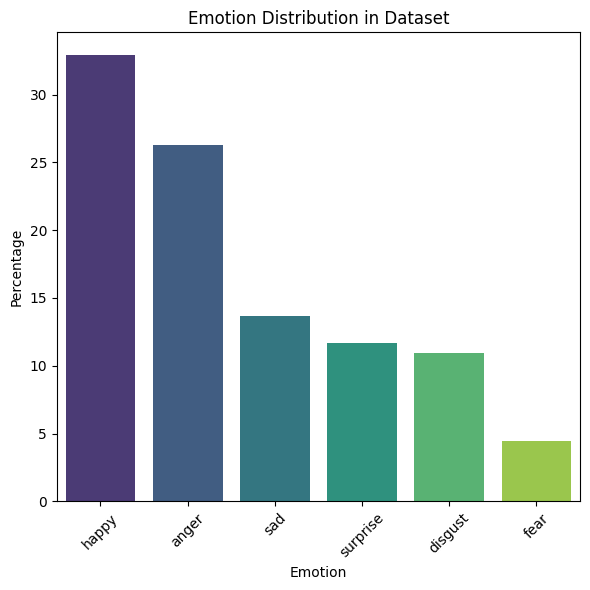

In [46]:
label_to_emotion = {v: k for k, v in non_neutral_to_label.items()}
emotion_counts_i = emotion_df['emotion_label'].value_counts(normalize=True) * 100

plot_df = pd.DataFrame({
    "Emotion": [label_to_emotion[label] for label in emotion_counts_i.index],
    "Percentage": emotion_counts_i.values
})

fig, ax = plt.subplots(figsize=(6, 6))
sns.barplot(data=plot_df, x="Emotion", y="Percentage", hue="Emotion", palette="viridis", ax=ax, legend=False)

ax.set_title('Emotion Distribution in Dataset')
ax.set_xlabel('Emotion')
ax.set_ylabel('Percentage')
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [47]:
emotion_df['emotion_label'].value_counts()

,count
emotion_label,
0,2540
1,2029
2,1052
3,902
5,844
4,344


#### General setup:

In [23]:
from transformers import EarlyStoppingCallback
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from transformers import AutoConfig, AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

In [16]:
# MODEL_NAME = "answerdotai/ModernBERT-base"
MODEL_NAME = "michellejieli/emotion_text_classifier"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/413 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

In [17]:
early_stopping = EarlyStoppingCallback(
  early_stopping_patience=2
)

In [18]:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = np.argmax(pred.predictions, axis=1)
  acc = accuracy_score(labels, preds)
  f1 = f1_score(labels, preds, average='weighted')
  return {'accuracy': acc, 'f1': f1}

def plot_confusion_matrix(true, pred, title):
  cm = confusion_matrix(true, pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Neutral", "Non-Neutral"])
  disp.plot(cmap="viridis")
  plt.title(title)
  plt.show()

##### Binary model:

In [19]:
temp_texts, test_texts, temp_labels, test_labels = train_test_split(
  binary_df['text'].tolist(), binary_df['binary_label'].tolist(),
  test_size=0.2, random_state=42, stratify=binary_df['binary_label']
)

train_texts, val_texts, train_labels, val_labels = train_test_split(
  temp_texts, temp_labels, test_size=0.2, random_state=42, stratify=temp_labels
)

In [20]:
class BinaryEmotionDataset(Dataset):
  def __init__(self, texts, labels, tokenizer, max_len=128):
    self.texts = texts
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    encoding = self.tokenizer(
      self.texts[idx],
      truncation=True,
      padding='max_length',
      max_length=self.max_len,
      return_tensors='pt'
    )
    return {
      'input_ids': encoding['input_ids'].squeeze(),
      'attention_mask': encoding['attention_mask'].squeeze(),
      'labels': torch.tensor(self.labels[idx], dtype=torch.long)
    }

In [21]:
train_dataset = BinaryEmotionDataset(train_texts, train_labels, tokenizer)
val_dataset = BinaryEmotionDataset(val_texts, val_labels, tokenizer)
test_dataset = BinaryEmotionDataset(test_texts, test_labels, tokenizer)

In [24]:
config = AutoConfig.from_pretrained(MODEL_NAME)
config.num_labels = 2

model = AutoModelForSequenceClassification.from_pretrained(
  MODEL_NAME,
  config=config,
  ignore_mismatched_sizes=True
).to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at michellejieli/emotion_text_classifier and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([7, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([7]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
# model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2).to(device)

In [ ]:
# from transformers import TrainingArguments, IntervalStrategy

# training_args = TrainingArguments(
#   output_dir='./results',
#   overwrite_output_dir=True,
#   do_train=True,
#   do_eval=True,
#   per_device_train_batch_size=32,
#   per_device_eval_batch_size=32,
#   learning_rate=5e-5,
#   weight_decay=0.01,
#   logging_dir='./logs',
#   logging_steps=10,
#   save_steps=10,
#   save_total_limit=2,
#   fp16=True,
#   load_best_model_at_end=True,
#   metric_for_best_model='accuracy',
#   greater_is_better=True,
#   eval_strategy=IntervalStrategy.EPOCH,
#   save_strategy=IntervalStrategy.EPOCH,
#   num_train_epochs=5
# )

In [26]:
from sklearn.metrics import accuracy_score

def compute_metrics(p):
  preds = p.predictions.argmax(axis=-1)
  return {"accuracy": accuracy_score(p.label_ids, preds)}

In [27]:
from transformers import Trainer, TrainingArguments, IntervalStrategy

training_args = TrainingArguments(
  output_dir='./results',
  overwrite_output_dir=True,
  do_train=True,
  do_eval=True,
  per_device_train_batch_size=32,
  per_device_eval_batch_size=32,
  learning_rate=5e-5,
  weight_decay=0.01,
  logging_dir='./logs',
  logging_steps=10,
  save_steps=10,
  save_total_limit=2,
  fp16=True,
  load_best_model_at_end=True,
  metric_for_best_model='accuracy',
  greater_is_better=True,
  eval_strategy=IntervalStrategy.EPOCH,
  save_strategy=IntervalStrategy.EPOCH,
  num_train_epochs=5,
  report_to="tensorboard"
)

In [28]:
trainer = Trainer(
  model=model,
  args=training_args,
  train_dataset=train_dataset,
  eval_dataset=val_dataset,
  tokenizer=tokenizer,
  compute_metrics=compute_metrics,
  callbacks=[early_stopping]
)

<ipython-input-28-f63fbe8470ee>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [29]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.661300,0.646985,0.628195
2,0.638300,0.645731,0.642484
3,0.592500,0.649768,0.651553
4,0.425900,0.774561,0.627095
5,0.387700,0.897473,0.622973


TrainOutput(global_step=2275, training_loss=0.5299290936857789, metrics={'train_runtime': 313.2428, 'train_samples_per_second': 232.296, 'train_steps_per_second': 7.263, 'total_flos': 2409747565800960.0, 'train_loss': 0.5299290936857789, 'epoch': 5.0})

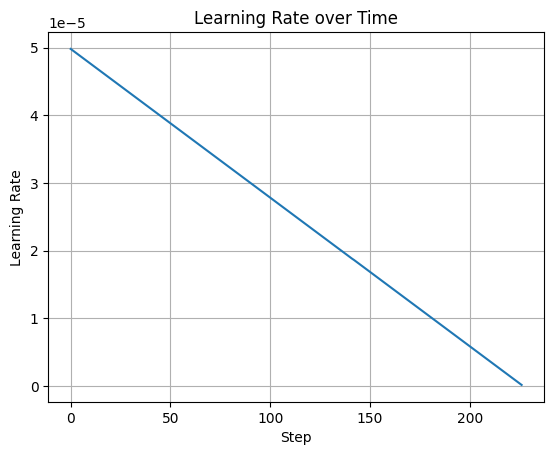

In [30]:
from transformers.integrations import TensorBoardCallback

logs = trainer.state.log_history
lrs = [log["learning_rate"] for log in logs if "learning_rate" in log]
steps = list(range(len(lrs)))

plt.plot(steps, lrs)
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Learning Rate over Time")
plt.grid(True)
plt.show()

In [31]:
# results = trainer.evaluate()
# print(results)

Validation metrics:


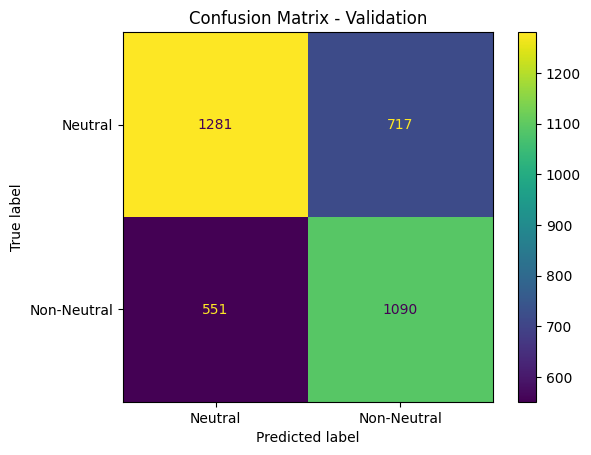

Train metrics:


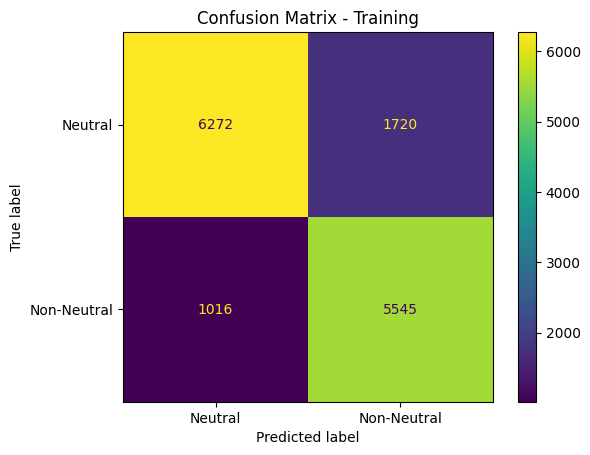

Test metrics:


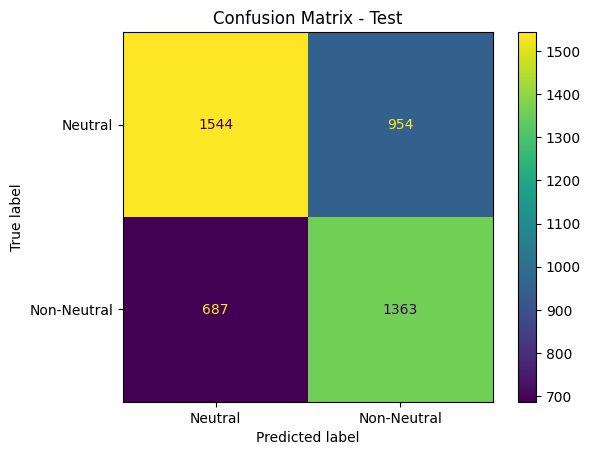

Train: {'accuracy': 0.8119975262832406}
Val: {'accuracy': 0.6515526243473482}
Test: {'accuracy': 0.6391820580474934}


In [32]:
def evaluate_and_plot(trainer, dataset, name):
  preds_output = trainer.predict(dataset)
  preds = np.argmax(preds_output.predictions, axis=1)
  labels = preds_output.label_ids
  plot_confusion_matrix(labels, preds, f"Confusion Matrix - {name}")
  return compute_metrics(preds_output)

print("Validation metrics:")
val_metrics = evaluate_and_plot(trainer, val_dataset, "Validation")

print("Train metrics:")
train_metrics = evaluate_and_plot(trainer, train_dataset, "Training")

print("Test metrics:")
test_metrics = evaluate_and_plot(trainer, test_dataset, "Test")

print("Train:", train_metrics)
print("Val:", val_metrics)
print("Test:", test_metrics)

In [35]:
output_dir = "./distil_bert_binary_model"

model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('./distil_bert_binary_model/tokenizer_config.json',
 './distil_bert_binary_model/special_tokens_map.json',
 './distil_bert_binary_model/vocab.json',
 './distil_bert_binary_model/merges.txt',
 './distil_bert_binary_model/added_tokens.json',
 './distil_bert_binary_model/tokenizer.json')

In [36]:
import shutil

shutil.make_archive("distil_bert_binary_model", 'zip', output_dir)

'/content/distil_bert_binary_model.zip'

In [37]:
from google.colab import files

files.download("distil_bert_binary_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##### Non-neutral emotions model:

In [38]:
print("Clearing GPU cache...")
torch.cuda.empty_cache()

Clearing GPU cache...


In [39]:
import gc
import torch

# del train_texts, val_texts, test_texts
# del train_labels, val_labels, test_labels
# del temp_texts, temp_labels
# del train_dataset, val_dataset, test_dataset

del logs, lrs, steps

gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [48]:
temp_texts, test_texts, temp_labels, test_labels = train_test_split(
  emotion_df['text'].tolist(), emotion_df['emotion_label'].tolist(),
  test_size=0.2, random_state=42, stratify=emotion_df['emotion_label']
)

train_texts, val_texts, train_labels, val_labels = train_test_split(
  temp_texts, temp_labels, test_size=0.2, random_state=42, stratify=temp_labels
)

In [49]:
class EmotionDataset(Dataset):
  def __init__(self, texts, labels, tokenizer, max_len=128):
    self.texts = texts
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    encoding = self.tokenizer(
      self.texts[idx],
      truncation=True,
      padding='max_length',
      max_length=self.max_len,
      return_tensors='pt'
    )
    return {
      'input_ids': encoding['input_ids'].squeeze(),
      'attention_mask': encoding['attention_mask'].squeeze(),
      'labels': torch.tensor(self.labels[idx], dtype=torch.long)
    }

In [50]:
train_dataset = EmotionDataset(train_texts, train_labels, tokenizer)
val_dataset = EmotionDataset(val_texts, val_labels, tokenizer)
test_dataset = EmotionDataset(test_texts, test_labels, tokenizer)

In [51]:
config = AutoConfig.from_pretrained(MODEL_NAME)
config.num_labels = 6

model = AutoModelForSequenceClassification.from_pretrained(
  MODEL_NAME,
  config=config,
  ignore_mismatched_sizes=True
).to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at michellejieli/emotion_text_classifier and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([7, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([7]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [52]:
# model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=6).to(device)

In [53]:
from sklearn.metrics import accuracy_score

def compute_metrics(p):
  preds = p.predictions.argmax(axis=-1)
  return {"accuracy": accuracy_score(p.label_ids, preds)}

In [54]:
from transformers import Trainer, TrainingArguments, IntervalStrategy

training_args = TrainingArguments(
  output_dir='./emotion_results',
  overwrite_output_dir=True,
  do_train=True,
  do_eval=True,
  per_device_train_batch_size=32,
  per_device_eval_batch_size=32,
  learning_rate=5e-5,
  weight_decay=0.01,
  logging_dir='./emotion_logs',
  logging_steps=10,
  save_steps=10,
  save_total_limit=2,
  fp16=True,
  load_best_model_at_end=True,
  metric_for_best_model='accuracy',
  greater_is_better=True,
  eval_strategy=IntervalStrategy.EPOCH,
  save_strategy=IntervalStrategy.EPOCH,
  num_train_epochs=5,
  report_to="tensorboard"
)

In [55]:
trainer = Trainer(
  model=model,
  args=training_args,
  train_dataset=train_dataset,
  eval_dataset=val_dataset,
  tokenizer=tokenizer,
  compute_metrics=compute_metrics,
  callbacks=[early_stopping]
)

<ipython-input-55-f63fbe8470ee>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [56]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.523100,1.495688,0.438412
2,1.389100,1.519024,0.438412
3,1.193700,1.597728,0.429498


TrainOutput(global_step=465, training_loss=1.3660109519958497, metrics={'train_runtime': 78.7673, 'train_samples_per_second': 313.201, 'train_steps_per_second': 9.839, 'total_flos': 490230576497664.0, 'train_loss': 1.3660109519958497, 'epoch': 3.0})

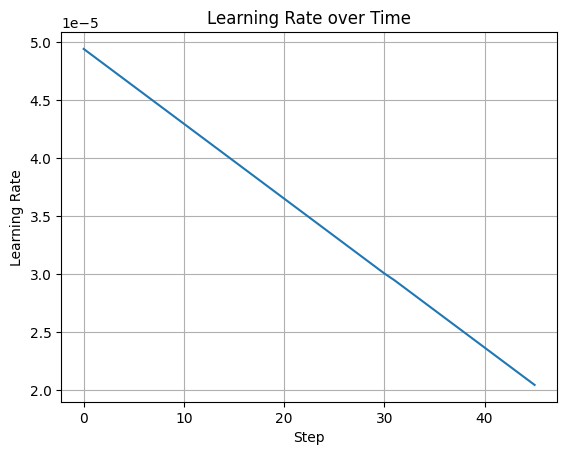

In [57]:
from transformers.integrations import TensorBoardCallback

logs = trainer.state.log_history
lrs = [log["learning_rate"] for log in logs if "learning_rate" in log]
steps = list(range(len(lrs)))

plt.plot(steps, lrs)
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Learning Rate over Time")
plt.grid(True)
plt.show()

In [58]:
# results = trainer.evaluate()
# print(results)

In [59]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
  cm = confusion_matrix(y_true, y_pred)
  num_classes = cm.shape[0]
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(num_classes)))
  disp.plot(cmap='Blues')
  plt.title(title)
  plt.grid(False)
  plt.show()

Validation metrics:


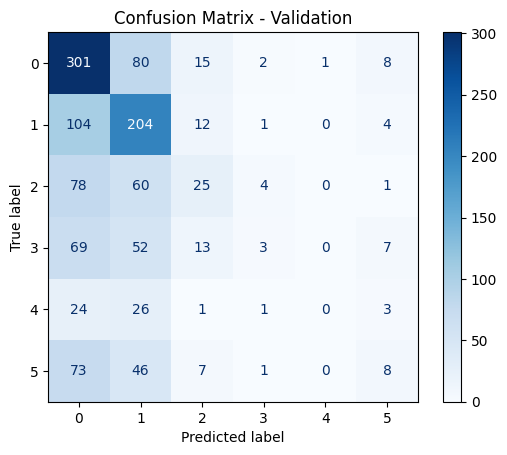

Train metrics:


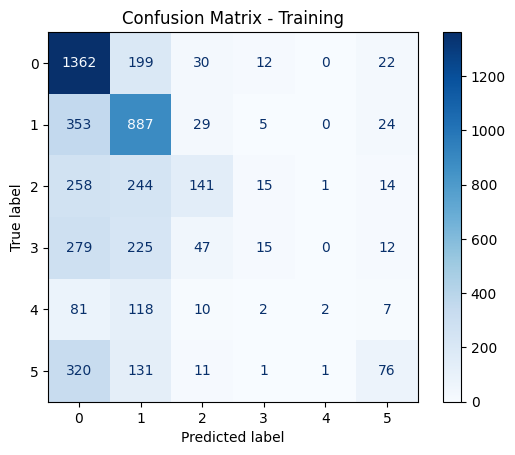

Test metrics:


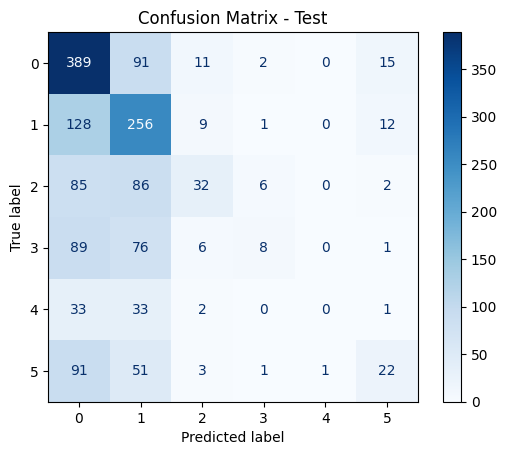

Train: {'accuracy': 0.5032428050263478}
Val: {'accuracy': 0.43841166936790926}
Test: {'accuracy': 0.458198314970836}


In [60]:
def evaluate_and_plot(trainer, dataset, name):
  preds_output = trainer.predict(dataset)
  preds = np.argmax(preds_output.predictions, axis=1)
  labels = preds_output.label_ids
  plot_confusion_matrix(labels, preds, f"Confusion Matrix - {name}")
  return compute_metrics(preds_output)

print("Validation metrics:")
val_metrics = evaluate_and_plot(trainer, val_dataset, "Validation")

print("Train metrics:")
train_metrics = evaluate_and_plot(trainer, train_dataset, "Training")

print("Test metrics:")
test_metrics = evaluate_and_plot(trainer, test_dataset, "Test")

print("Train:", train_metrics)
print("Val:", val_metrics)
print("Test:", test_metrics)

In [61]:
output_dir = "./distil_bert_emotion_model"

model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('./distil_bert_emotion_model/tokenizer_config.json',
 './distil_bert_emotion_model/special_tokens_map.json',
 './distil_bert_emotion_model/vocab.json',
 './distil_bert_emotion_model/merges.txt',
 './distil_bert_emotion_model/added_tokens.json',
 './distil_bert_emotion_model/tokenizer.json')

In [62]:
import shutil

shutil.make_archive("distil_bert_emotion_model", 'zip', output_dir)

'/content/distil_bert_emotion_model.zip'

In [63]:
from google.colab import files

files.download("distil_bert_emotion_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##### Non-neutral emotions model weighted:

In [64]:
print("Clearing GPU cache...")
torch.cuda.empty_cache()

Clearing GPU cache...


In [65]:
import gc
import torch

# del train_texts, val_texts, test_texts
# del train_labels, val_labels, test_labels
# del temp_texts, temp_labels
# del train_dataset, val_dataset, test_dataset

del logs, lrs, steps

gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

labels = emotion_df['emotion_label']
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

print("Class weights:", class_weights)

Class weights: tensor([0.5060, 0.6334, 1.2216, 1.4248, 3.7359, 1.5227], device='cuda:0')


In [ ]:
temp_texts, test_texts, temp_labels, test_labels = train_test_split(
  emotion_df['text'].tolist(), emotion_df['emotion_label'].tolist(),
  test_size=0.2, random_state=42, stratify=emotion_df['emotion_label']
)

train_texts, val_texts, train_labels, val_labels = train_test_split(
  temp_texts, temp_labels, test_size=0.2, random_state=42, stratify=temp_labels
)

In [ ]:
class EmotionDataset(Dataset):
  def __init__(self, texts, labels, tokenizer, max_len=128):
    self.texts = texts
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    encoding = self.tokenizer(
      self.texts[idx],
      truncation=True,
      padding='max_length',
      max_length=self.max_len,
      return_tensors='pt'
    )
    return {
      'input_ids': encoding['input_ids'].squeeze(),
      'attention_mask': encoding['attention_mask'].squeeze(),
      'labels': torch.tensor(self.labels[idx], dtype=torch.long)
    }

In [ ]:
train_dataset = EmotionDataset(train_texts, train_labels, tokenizer)
val_dataset = EmotionDataset(val_texts, val_labels, tokenizer)
test_dataset = EmotionDataset(test_texts, test_labels, tokenizer)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=6).to(device)

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.metrics import accuracy_score

def compute_metrics(p):
  preds = p.predictions.argmax(axis=-1)
  return {"accuracy": accuracy_score(p.label_ids, preds)}

In [ ]:
from transformers import Trainer
from torch import nn

class WeightedTrainer(Trainer):
  def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
    labels = inputs.pop("labels")
    outputs = model(**inputs)
    logits = outputs.logits
    loss_fct = nn.CrossEntropyLoss(weight=class_weights)
    loss = loss_fct(logits, labels)
    return (loss, outputs) if return_outputs else loss

In [ ]:
from transformers import Trainer, TrainingArguments, IntervalStrategy

training_args = TrainingArguments(
  output_dir='./emotion_results',
  overwrite_output_dir=True,
  do_train=True,
  do_eval=True,
  per_device_train_batch_size=32,
  per_device_eval_batch_size=32,
  learning_rate=5e-5,
  weight_decay=0.01,
  logging_dir='./emotion_logs',
  logging_steps=10,
  save_steps=10,
  save_total_limit=2,
  fp16=True,
  load_best_model_at_end=True,
  metric_for_best_model='accuracy',
  greater_is_better=True,
  eval_strategy=IntervalStrategy.EPOCH,
  save_strategy=IntervalStrategy.EPOCH,
  num_train_epochs=5,
  report_to="tensorboard"
)

In [ ]:
trainer = WeightedTrainer(
  model=model,
  args=training_args,
  train_dataset=train_dataset,
  eval_dataset=val_dataset,
  tokenizer=tokenizer,
  compute_metrics=compute_metrics,
  callbacks=[early_stopping]
)

<ipython-input-89-bb06c1b39ff1>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.723900,1.676748,0.351702
2,1.519700,1.719371,0.370340
3,0.643400,2.622611,0.376013
4,0.134800,4.387859,0.399514
5,0.016200,4.998020,0.401135


TrainOutput(global_step=775, training_loss=0.7935951103606532, metrics={'train_runtime': 882.3229, 'train_samples_per_second': 27.96, 'train_steps_per_second': 0.878, 'total_flos': 6522554378787840.0, 'train_loss': 0.7935951103606532, 'epoch': 5.0})

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
  cm = confusion_matrix(y_true, y_pred)
  num_classes = cm.shape[0]
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(num_classes)))
  disp.plot(cmap='Blues')
  plt.title(title)
  plt.grid(False)
  plt.show()

Validation metrics:


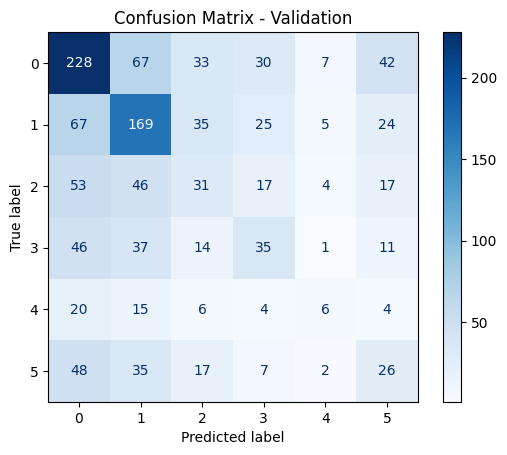

Train metrics:


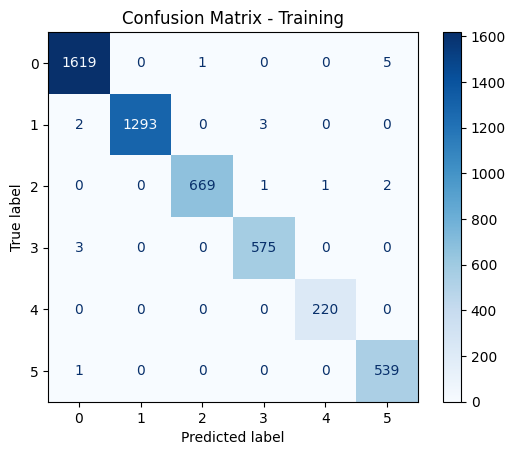

Test metrics:


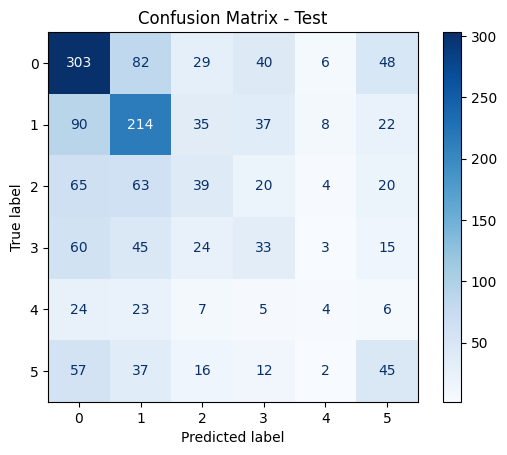

Train: {'accuracy': 0.996149169031212}
Val: {'accuracy': 0.4011345218800648}
Test: {'accuracy': 0.4134802333117304}


In [ ]:
def evaluate_and_plot(trainer, dataset, name):
  preds_output = trainer.predict(dataset)
  preds = np.argmax(preds_output.predictions, axis=1)
  labels = preds_output.label_ids
  plot_confusion_matrix(labels, preds, f"Confusion Matrix - {name}")
  return compute_metrics(preds_output)

print("Validation metrics:")
val_metrics = evaluate_and_plot(trainer, val_dataset, "Validation")

print("Train metrics:")
train_metrics = evaluate_and_plot(trainer, train_dataset, "Training")

print("Test metrics:")
test_metrics = evaluate_and_plot(trainer, test_dataset, "Test")

print("Train:", train_metrics)
print("Val:", val_metrics)
print("Test:", test_metrics)

In [ ]:
output_dir = "./modernbert_emotion_model_weighted"

model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('./modernbert_emotion_model_weighted/tokenizer_config.json',
 './modernbert_emotion_model_weighted/special_tokens_map.json',
 './modernbert_emotion_model_weighted/tokenizer.json')

In [ ]:
import shutil

shutil.make_archive("modernbert_emotion_model_weighted", 'zip', output_dir)

'/content/modernbert_emotion_model_weighted.zip'

In [ ]:
from google.colab import files

files.download("modernbert_emotion_model_weighted.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##### Non-neutral emotions model oversampled:

In [66]:
print("Clearing GPU cache...")
torch.cuda.empty_cache()

Clearing GPU cache...


In [67]:
import gc
import torch

# del train_texts, val_texts, test_texts
# del train_labels, val_labels, test_labels
# del temp_texts, temp_labels
# del train_dataset, val_dataset, test_dataset

# del logs, lrs, steps

gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [68]:
!pip install -q imbalanced-learn

In [69]:
temp_texts, test_texts, temp_labels, test_labels = train_test_split(
  emotion_df['text'].tolist(), emotion_df['emotion_label'].tolist(),
  test_size=0.2, random_state=42, stratify=emotion_df['emotion_label']
)

train_texts, val_texts, train_labels, val_labels = train_test_split(
  temp_texts, temp_labels, test_size=0.2, random_state=42, stratify=temp_labels
)

In [70]:
from imblearn.over_sampling import RandomOverSampler

X_train = np.array(train_texts)
y_train = np.array(train_labels)

X_train = X_train.reshape(-1, 1)

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

train_texts = X_resampled.flatten().tolist()
train_labels = y_resampled.tolist()

from collections import Counter
print("Resampled training distribution:", Counter(train_labels))

Resampled training distribution: Counter({1: 1625, 0: 1625, 3: 1625, 5: 1625, 2: 1625, 4: 1625})


In [71]:
class EmotionDataset(Dataset):
  def __init__(self, texts, labels, tokenizer, max_len=128):
    self.texts = texts
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    encoding = self.tokenizer(
      self.texts[idx],
      truncation=True,
      padding='max_length',
      max_length=self.max_len,
      return_tensors='pt'
    )
    return {
      'input_ids': encoding['input_ids'].squeeze(),
      'attention_mask': encoding['attention_mask'].squeeze(),
      'labels': torch.tensor(self.labels[idx], dtype=torch.long)
    }

In [72]:
train_dataset = EmotionDataset(train_texts, train_labels, tokenizer)
val_dataset = EmotionDataset(val_texts, val_labels, tokenizer)
test_dataset = EmotionDataset(test_texts, test_labels, tokenizer)

In [73]:
config = AutoConfig.from_pretrained(MODEL_NAME)
config.num_labels = 6

model = AutoModelForSequenceClassification.from_pretrained(
  MODEL_NAME,
  config=config,
  ignore_mismatched_sizes=True
).to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at michellejieli/emotion_text_classifier and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([7, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([7]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [74]:
from sklearn.metrics import accuracy_score

def compute_metrics(p):
  preds = p.predictions.argmax(axis=-1)
  return {"accuracy": accuracy_score(p.label_ids, preds)}

In [75]:
from transformers import Trainer, TrainingArguments, IntervalStrategy

training_args = TrainingArguments(
  output_dir='./emotion_results',
  overwrite_output_dir=True,
  do_train=True,
  do_eval=True,
  per_device_train_batch_size=32,
  per_device_eval_batch_size=32,
  learning_rate=5e-5,
  weight_decay=0.01,
  logging_dir='./emotion_logs',
  logging_steps=10,
  save_steps=10,
  save_total_limit=2,
  fp16=True,
  load_best_model_at_end=True,
  metric_for_best_model='accuracy',
  greater_is_better=True,
  eval_strategy=IntervalStrategy.EPOCH,
  save_strategy=IntervalStrategy.EPOCH,
  num_train_epochs=5,
  report_to="tensorboard"
)

In [76]:
trainer = Trainer(
  model=model,
  args=training_args,
  train_dataset=train_dataset,
  eval_dataset=val_dataset,
  tokenizer=tokenizer,
  compute_metrics=compute_metrics,
  callbacks=[early_stopping]
)

<ipython-input-76-f63fbe8470ee>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [77]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.210000,1.689617,0.340357
2,0.931200,1.887696,0.372771
3,0.491700,2.191846,0.378444
4,0.356300,2.369411,0.385737
5,0.189000,2.456256,0.400324


TrainOutput(global_step=1525, training_loss=0.709554220457546, metrics={'train_runtime': 229.1205, 'train_samples_per_second': 212.77, 'train_steps_per_second': 6.656, 'total_flos': 1614561586560000.0, 'train_loss': 0.709554220457546, 'epoch': 5.0})

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
  cm = confusion_matrix(y_true, y_pred)
  num_classes = cm.shape[0]
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(num_classes)))
  disp.plot(cmap='Blues')
  plt.title(title)
  plt.grid(False)
  plt.show()

In [ ]:
def evaluate_and_plot(trainer, dataset, name):
  preds_output = trainer.predict(dataset)
  preds = np.argmax(preds_output.predictions, axis=1)
  labels = preds_output.label_ids
  plot_confusion_matrix(labels, preds, f"Confusion Matrix - {name}")
  return compute_metrics(preds_output)

print("Validation metrics:")
val_metrics = evaluate_and_plot(trainer, val_dataset, "Validation")

print("Train metrics:")
train_metrics = evaluate_and_plot(trainer, train_dataset, "Training")

print("Test metrics:")
test_metrics = evaluate_and_plot(trainer, test_dataset, "Test")

print("Train:", train_metrics)
print("Val:", val_metrics)
print("Test:", test_metrics)

In [ ]:
output_dir = "./modernbert_emotion_model_oversampled"

model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

In [ ]:
import shutil

shutil.make_archive("modernbert_emotion_model_oversampled", 'zip', output_dir)

In [ ]:
from google.colab import files

files.download("modernbert_emotion_model_oversampled.zip")

#### Draft:

###### Non-neutral emotions data:

In [85]:
all_emotions_df = df[['text', 'emotion_label']].copy()

all_emotions_df['emotion_label'], _ = pd.factorize(all_emotions_df['emotion_label'])
all_emotions_df.head()

,text,emotion_label
0,"Ross: Hi... There she is. Hi Emma. Oh my God,...",0
1,"Rachel: That was one time, Ross, and they were...",1
2,"Ross: Ooh hey, Emma, daddy has some presents f...",1
3,"Rachel: Aaah... Ross, actually there's somethi...",2
4,"Ross: Okay, shoot! \n",1


In [86]:
all_emotions_df = all_emotions_df[all_emotions_df['text'] != '-'].reset_index(drop=True)

In [87]:
all_emotions_df['emotion_label'].value_counts()

,count
emotion_label,
1,12488
0,5081
2,2029
3,1052
4,902
6,844
5,344


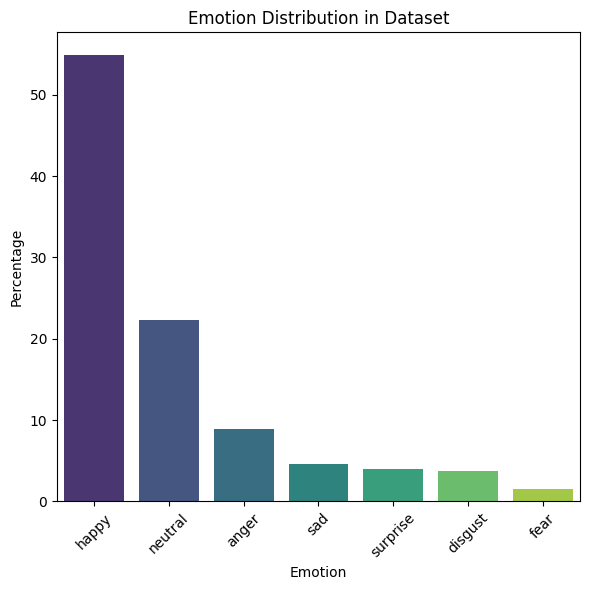

In [88]:
label_to_emotion = {v: k for k, v in emotion_to_label.items()}
emotion_counts_i = all_emotions_df['emotion_label'].value_counts(normalize=True) * 100

plot_df = pd.DataFrame({
    "Emotion": [label_to_emotion[label] for label in emotion_counts_i.index],
    "Percentage": emotion_counts_i.values
})

fig, ax = plt.subplots(figsize=(6, 6))
sns.barplot(data=plot_df, x="Emotion", y="Percentage", hue="Emotion", palette="viridis", ax=ax, legend=False)

ax.set_title('Emotion Distribution in Dataset')
ax.set_xlabel('Emotion')
ax.set_ylabel('Percentage')
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [89]:
happy_df = all_emotions_df[all_emotions_df['emotion_label'] == 1]
happy_df_reduced = happy_df.sample(frac=0.5, random_state=42)

others_df = all_emotions_df[all_emotions_df['emotion_label'] != 1]

all_emotions_df_reduced = pd.concat([happy_df_reduced, others_df], ignore_index=True)
all_emotions_df = all_emotions_df_reduced.sample(frac=1, random_state=42).reset_index(drop=True)
all_emotions_df.head()

,text,emotion_label
0,Jay : Nothing. I told some jokes.\n,0
1,Joey: Awww...I don't know Monica...You know......,1
2,Bitsy: It's so nice to finally meet you! \n,0
3,Phoebe: Or we could use it to call China. See ...,0
4,"Chandler: What, Ethan? He got to spend the who...",1


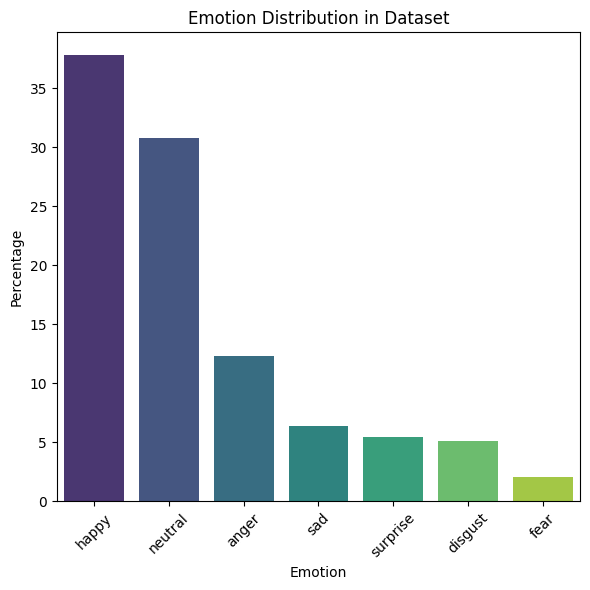

In [90]:
label_to_emotion = {v: k for k, v in emotion_to_label.items()}
emotion_counts_i = all_emotions_df['emotion_label'].value_counts(normalize=True) * 100

plot_df = pd.DataFrame({
    "Emotion": [label_to_emotion[label] for label in emotion_counts_i.index],
    "Percentage": emotion_counts_i.values
})

fig, ax = plt.subplots(figsize=(6, 6))
sns.barplot(data=plot_df, x="Emotion", y="Percentage", hue="Emotion", palette="viridis", ax=ax, legend=False)

ax.set_title('Emotion Distribution in Dataset')
ax.set_xlabel('Emotion')
ax.set_ylabel('Percentage')
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [91]:
all_emotions_df['emotion_label'].value_counts()

,count
emotion_label,
1,6244
0,5081
2,2029
3,1052
4,902
6,844
5,344


##### All emotions model:

In [92]:
print("Clearing GPU cache...")
torch.cuda.empty_cache()

Clearing GPU cache...


In [94]:
import gc
import torch

# del train_texts, val_texts, test_texts
# del train_labels, val_labels, test_labels
# del temp_texts, temp_labels
# del train_dataset, val_dataset, test_dataset

# del logs, lrs, steps

gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [96]:
temp_texts, test_texts, temp_labels, test_labels = train_test_split(
  all_emotions_df['text'].tolist(), all_emotions_df['emotion_label'].tolist(),
  test_size=0.2, random_state=42, stratify=all_emotions_df['emotion_label']
)

train_texts, val_texts, train_labels, val_labels = train_test_split(
  temp_texts, temp_labels, test_size=0.2, random_state=42, stratify=temp_labels
)

In [97]:
class EmotionDataset(Dataset):
  def __init__(self, texts, labels, tokenizer, max_len=128):
    self.texts = texts
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    encoding = self.tokenizer(
      self.texts[idx],
      truncation=True,
      padding='max_length',
      max_length=self.max_len,
      return_tensors='pt'
    )
    return {
      'input_ids': encoding['input_ids'].squeeze(),
      'attention_mask': encoding['attention_mask'].squeeze(),
      'labels': torch.tensor(self.labels[idx], dtype=torch.long)
    }

In [98]:
train_dataset = EmotionDataset(train_texts, train_labels, tokenizer)
val_dataset = EmotionDataset(val_texts, val_labels, tokenizer)
test_dataset = EmotionDataset(test_texts, test_labels, tokenizer)

In [101]:
# config = AutoConfig.from_pretrained(MODEL_NAME)
# config.num_labels = 6

# model = AutoModelForSequenceClassification.from_pretrained(
#   MODEL_NAME,
#   config=config,
#   ignore_mismatched_sizes=True
# ).to(device)

In [100]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=7).to(device)

In [102]:
from sklearn.metrics import accuracy_score

def compute_metrics(p):
  preds = p.predictions.argmax(axis=-1)
  return {"accuracy": accuracy_score(p.label_ids, preds)}

In [103]:
from transformers import Trainer, TrainingArguments, IntervalStrategy

training_args = TrainingArguments(
  output_dir='./all_emotion_results',
  overwrite_output_dir=True,
  do_train=True,
  do_eval=True,
  per_device_train_batch_size=32,
  per_device_eval_batch_size=32,
  learning_rate=5e-5,
  weight_decay=0.01,
  logging_dir='./all_emotion_logs',
  logging_steps=10,
  save_steps=10,
  save_total_limit=2,
  fp16=True,
  load_best_model_at_end=True,
  metric_for_best_model='accuracy',
  greater_is_better=True,
  eval_strategy=IntervalStrategy.EPOCH,
  save_strategy=IntervalStrategy.EPOCH,
  num_train_epochs=5,
  report_to="tensorboard"
)

In [104]:
trainer = Trainer(
  model=model,
  args=training_args,
  train_dataset=train_dataset,
  eval_dataset=val_dataset,
  tokenizer=tokenizer,
  compute_metrics=compute_metrics,
  callbacks=[early_stopping]
)

<ipython-input-104-f63fbe8470ee>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [105]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.412200,1.428177,0.459470
2,1.346100,1.412666,0.464773
3,1.227700,1.461614,0.451136
4,0.975700,1.569002,0.449621


TrainOutput(global_step=1320, training_loss=1.2901070580337988, metrics={'train_runtime': 187.8566, 'train_samples_per_second': 280.959, 'train_steps_per_second': 8.783, 'total_flos': 1398450545995776.0, 'train_loss': 1.2901070580337988, 'epoch': 4.0})

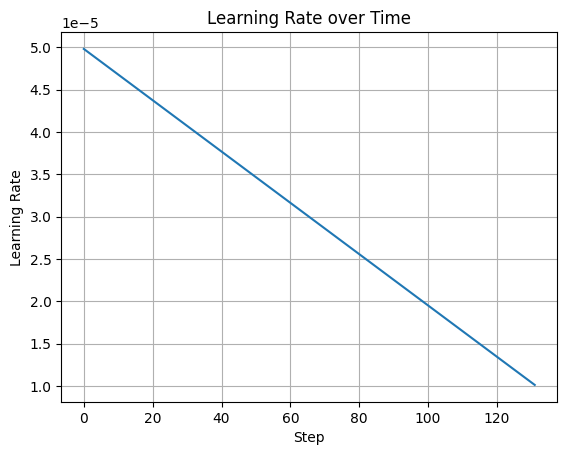

In [106]:
from transformers.integrations import TensorBoardCallback

logs = trainer.state.log_history
lrs = [log["learning_rate"] for log in logs if "learning_rate" in log]
steps = list(range(len(lrs)))

plt.plot(steps, lrs)
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Learning Rate over Time")
plt.grid(True)
plt.show()

In [107]:
# results = trainer.evaluate()
# print(results)

In [108]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
  cm = confusion_matrix(y_true, y_pred)
  num_classes = cm.shape[0]
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(num_classes)))
  disp.plot(cmap='Blues')
  plt.title(title)
  plt.grid(False)
  plt.show()

Validation metrics:


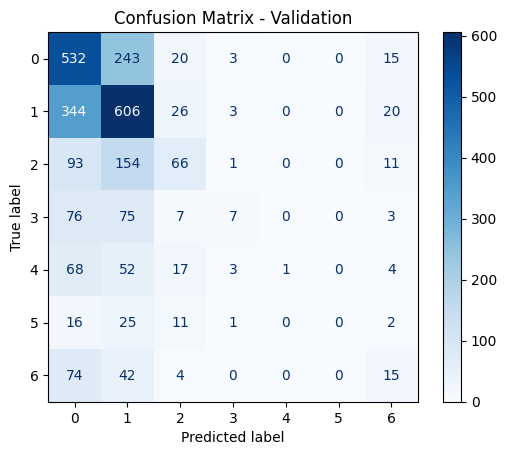

Train metrics:


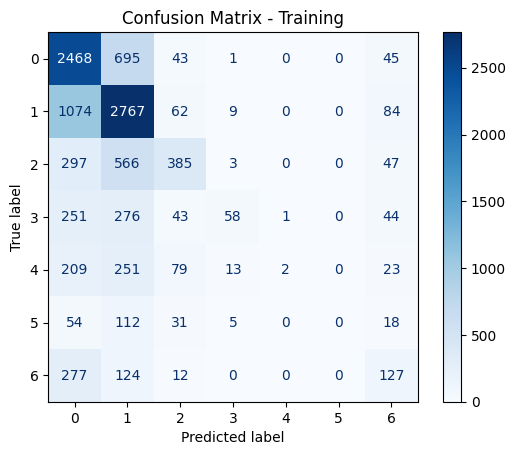

Test metrics:


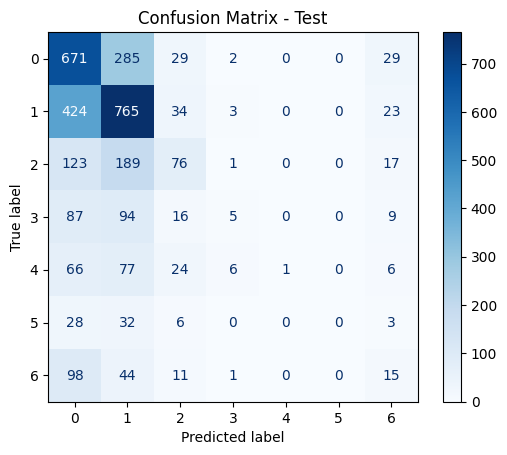

Train: {'accuracy': 0.5501136794240242}
Val: {'accuracy': 0.4647727272727273}
Test: {'accuracy': 0.46454545454545454}


In [109]:
def evaluate_and_plot(trainer, dataset, name):
  preds_output = trainer.predict(dataset)
  preds = np.argmax(preds_output.predictions, axis=1)
  labels = preds_output.label_ids
  plot_confusion_matrix(labels, preds, f"Confusion Matrix - {name}")
  return compute_metrics(preds_output)

print("Validation metrics:")
val_metrics = evaluate_and_plot(trainer, val_dataset, "Validation")

print("Train metrics:")
train_metrics = evaluate_and_plot(trainer, train_dataset, "Training")

print("Test metrics:")
test_metrics = evaluate_and_plot(trainer, test_dataset, "Test")

print("Train:", train_metrics)
print("Val:", val_metrics)
print("Test:", test_metrics)

In [110]:
output_dir = "./distil_bert_all_emotion_model"

model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('./distil_bert_all_emotion_model/tokenizer_config.json',
 './distil_bert_all_emotion_model/special_tokens_map.json',
 './distil_bert_all_emotion_model/vocab.json',
 './distil_bert_all_emotion_model/merges.txt',
 './distil_bert_all_emotion_model/added_tokens.json',
 './distil_bert_all_emotion_model/tokenizer.json')

In [111]:
import shutil

shutil.make_archive("distil_bert_all_emotion_model", 'zip', output_dir)

'/content/distil_bert_all_emotion_model.zip'

In [113]:
from google.colab import files

files.download("distil_bert_all_emotion_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>